# Gesture Recognition

In [1]:
#importing the required libraries.

In [3]:
import numpy as np
#!pip install scipy==1.1.0
import os
from scipy.misc import imread, imresize
import datetime
import os
import random
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
import pathlib
import matplotlib.pyplot as plt
import os
import imageio

In [2]:
#We set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [7]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 20

In [8]:
print(train_doc.shape)
print(val_doc.shape)

(663,)
(100,)


In [9]:
data_dir_train=pathlib.Path('/datasets/Project_data/train')
data_dir_val=pathlib.Path('/datasets/Project_data/val')

#### Visualise Random Images

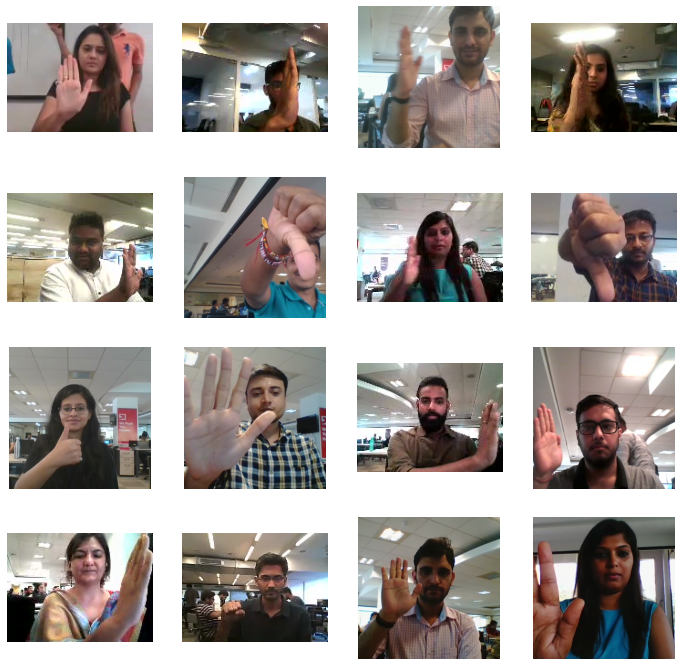

In [10]:
import random
from PIL import Image 

images = []
for folder in os.listdir(data_dir_train):
  for image in os.listdir(str(data_dir_train) + '/' + folder):
    images.append(os.path.join(data_dir_train, folder, image))

plt.figure(1, figsize=(12, 12))
plt.axis('off')
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = imageio.imread(random_img)
  plt.subplot(4, 4, n)
  plt.axis('off')
  plt.imshow(imgs)

plt.show()

## Generator

In [11]:
from tensorflow.python.framework.importer import import_graph_def_for_function
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,16)).astype('int')
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them.
                   
                    image=imresize(image,(120,120))
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

        
        # code for the remaining data points which are left after full batches
        rem_image=len(folder_list)%batch_size
        batch+=1
        if(rem_image!=0):
          batch_data = np.zeros((batch_size,len(img_idx),120,120,3))
          batch_labels = np.zeros((batch_size,5)) 
          for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    image=imresize(image,(120,120))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels 
          


Considering 25 epochs

In [12]:
import datetime
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


# Model 1- Conv3D Model : Batch size = 20,filtersize=(3,3,3)

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import LSTM,GRU,Bidirectional,SimpleRNN,RNN
from keras.regularizers import l2

filtersize=(3,3,3)
dropout=0.5
dense_neurons=256
num_classes=5

model=Sequential()

model.add(Conv3D(16, filtersize, padding='same',input_shape=(16,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(16, filtersize, padding='same',input_shape=(16,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))


model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes,activation='softmax'))


2022-10-09 13:35:55.204790: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-09 13:35:55.204853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [12]:
optimiser = keras.optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
#Model name is given in this format
model_name = 'model_init_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#Check if model exists or not in the directory, if not create it
if not os.path.exists(model_name):
    os.mkdir(model_name)

#Put more formatting
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Using callbacks reduce lr on plateau method 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/25


2022-10-09 13:35:59.006532: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.9316 - categorical_accuracy: 0.3632Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.96999, saving model to model_init_1_2022-10-0913_35_54.468561/model-00001-1.93157-0.36324-1.96999-0.21000.h5
34/34 [==============================] - 54s 1s/step - loss: 1.9316 - categorical_accuracy: 0.3632 - val_loss: 1.9700 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4938 - categorical_accuracy: 0.4765
Epoch 00002: val_loss did not improve from 1.96999
34/34 [==============================] - 47s 1s/step - loss: 1.4938 - categorical_accuracy: 0.4765 - val_loss: 2.6586 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1638 - categorical_accuracy: 0.5544
Epoch 00003: val_loss did not improve from 1.96999

Epoch 00003: ReduceLROnPlateau reduci

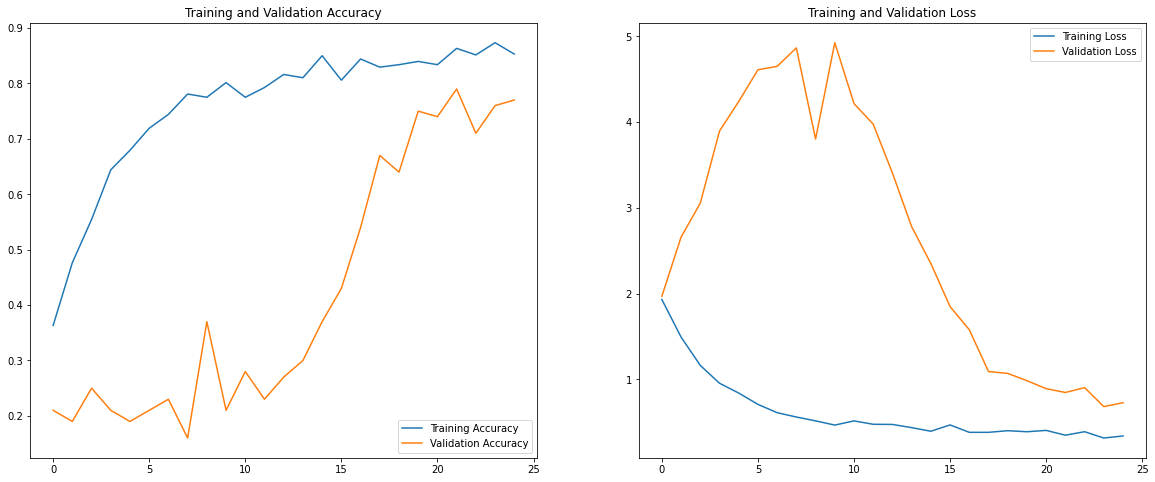

In [17]:
acc = model.history.history['categorical_accuracy']
val_acc = model.history.history['val_categorical_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### - The above model does overfit initially, but later improves.
##### - The loss and validation loss keeps reducing with epoch.

In [18]:
from keras.layers.convolutional import Conv2D,MaxPooling2D

# Model 2- Conv2D and LSTM , Batch size= 20, filtersize=(3,3)

In [19]:
model_2= Sequential()
filtersize=(3,3)

model_2.add(TimeDistributed(Conv2D(16,filtersize,padding='same',activation='relu'),input_shape=(16,120,120,3)))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D(2,2)))

model_2.add(TimeDistributed(Conv2D(32,filtersize,padding='same',activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D(2,2)))

model_2.add(TimeDistributed(Conv2D(64,filtersize,padding='same',activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D(2,2)))

model_2.add(TimeDistributed(Conv2D(128,filtersize,padding='same',activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D(2,2)))

model_2.add(TimeDistributed(Conv2D(256,filtersize,padding='same',activation='relu')))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D(2,2)))

model_2.add(TimeDistributed(Flatten()))
model_2.add(LSTM(256))
model_2.add(Dropout(0.25))

model_2.add(Dense(128,activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(num_classes,activation='softmax'))


In [20]:
optimiser = keras.optimizers.Adam(lr=0.0001)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 60, 60, 32)  

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
#Model name is given in this format
model_name = 'model_init_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#Check if model exists or not in the directory, if not create it
if not os.path.exists(model_name):
    os.mkdir(model_name)

#Put more formatting
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Using callbacks reduce lr on plateau method 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.4859 - categorical_accuracy: 0.3279Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.67131, saving model to model_init_2_2022-10-0913_35_54.468561/model-00001-1.48585-0.32794-1.67131-0.17000.h5
34/34 [==============================] - 50s 1s/step - loss: 1.4859 - categorical_accuracy: 0.3279 - val_loss: 1.6713 - val_categorical_accuracy: 0.1700 - lr: 1.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.0604 - categorical_accuracy: 0.5868
Epoch 00002: val_loss did not improve from 1.67131
34/34 [==============================] - 47s 1s/step - loss: 1.0604 - categorical_accuracy: 0.5868 - val_loss: 1.7167 - val_categorical_accuracy: 0.1500 - lr: 1.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.7986 - categorical_accuracy: 0.7044
Epoch 00003: val_

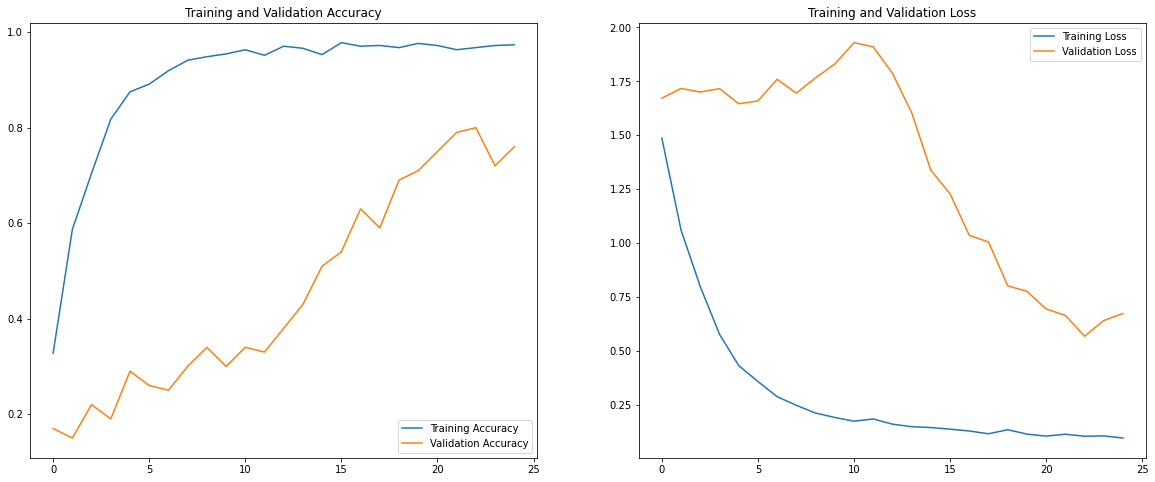

In [25]:
acc = model_2.history.history['categorical_accuracy']
val_acc = model_2.history.history['val_categorical_accuracy']

loss = model_2.history.history['loss']
val_loss = model_2.history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Model 2 overfits more compared to model 1. There is significant gap between training and val accuracy.
##### Validation loss is lower only to an extent. 

# Model 3- Conv3D Model : Batch size = 15,filtersize=(3,3,3)

#### Here we reduce the batch size and re-run model 1 and 2 . 

In [26]:
filtersize=(3,3,3)
dropout=0.5
dense_neurons=256
num_classes=5

model_3=Sequential()

model_3.add(Conv3D(16, filtersize, padding='same',input_shape=(16,120,120,3)))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())

model_3.add(Conv3D(16, filtersize, padding='same',input_shape=(16,120,120,3)))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())

model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(32, filtersize, padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())

model_3.add(Conv3D(32, filtersize, padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())

model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(64, filtersize, padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())

model_3.add(Conv3D(64, filtersize, padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())

model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(128, filtersize, padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())

model_3.add(Conv3D(128, filtersize, padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())

model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Flatten())
model_3.add(Dense(dense_neurons,activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(dropout))

model_3.add(Dense(dense_neurons,activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(dropout))

model_3.add(Dense(num_classes,activation='softmax'))


In [27]:
optimiser = keras.optimizers.Adam(lr=0.0002)
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_15 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_9 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_9 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_16 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [28]:
batch_size=15

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
#Model name is given in this format
model_name = 'model_init_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#Check if model exists or not in the directory, if not create it
if not os.path.exists(model_name):
    os.mkdir(model_name)

#Put more formatting
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Using callbacks reduce lr on plateau method 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [32]:
model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 2.0412 - categorical_accuracy: 0.3215Source path =  datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 2.02136, saving model to model_init_3_2022-10-0913_35_54.468561/model-00001-2.04122-0.32148-2.02136-0.15238.h5
45/45 [==============================] - 47s 1s/step - loss: 2.0412 - categorical_accuracy: 0.3215 - val_loss: 2.0214 - val_categorical_accuracy: 0.1524 - lr: 2.0000e-04
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.4289 - categorical_accuracy: 0.5022
Epoch 00002: val_loss did not improve from 2.02136
45/45 [==============================] - 43s 976ms/step - loss: 1.4289 - categorical_accuracy: 0.5022 - val_loss: 3.2833 - val_categorical_accuracy: 0.1714 - lr: 2.0000e-04
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 1.1296 - categorical_accuracy: 0.5644
Epoch 00003: v

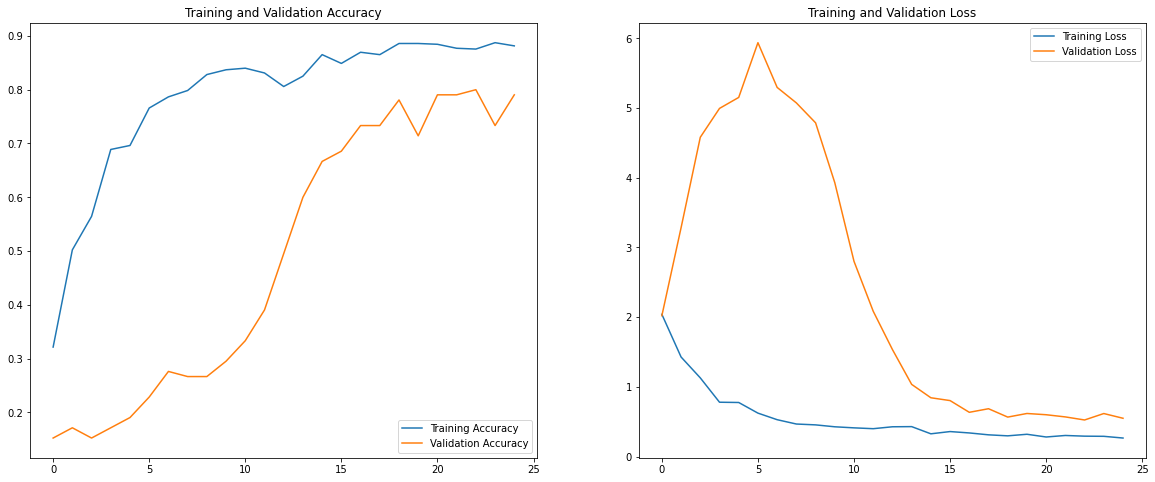

In [33]:
acc = model_3.history.history['categorical_accuracy']
val_acc = model_3.history.history['val_categorical_accuracy']

loss = model_3.history.history['loss']
val_loss = model_3.history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Reduction in batch size sees significant improvement in accuracy. Even the loss reduces considerably with every epoch.

# Model 4- Conv2D and LSTM , Batch size= 15, filtersize=(3,3)

In [34]:
model_4= Sequential()
filtersize=(3,3)

model_4.add(TimeDistributed(Conv2D(16,filtersize,padding='same',activation='relu'),input_shape=(16,120,120,3)))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D(2,2)))

model_4.add(TimeDistributed(Conv2D(32,filtersize,padding='same',activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D(2,2)))

model_4.add(TimeDistributed(Conv2D(64,filtersize,padding='same',activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D(2,2)))

model_4.add(TimeDistributed(Conv2D(128,filtersize,padding='same',activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D(2,2)))

model_4.add(TimeDistributed(Conv2D(256,filtersize,padding='same',activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D(2,2)))

model_4.add(TimeDistributed(Flatten()))
model_4.add(LSTM(256))
model_4.add(Dropout(0.25))

model_4.add(Dense(128,activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(num_classes,activation='softmax'))


In [35]:
optimiser = keras.optimizers.Adam(lr=0.0001)
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 60, 60, 32)  

In [36]:
batch_size=15

In [37]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [38]:
#Model name is given in this format
model_name = 'model_init_4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#Check if model exists or not in the directory, if not create it
if not os.path.exists(model_name):
    os.mkdir(model_name)

#Put more formatting
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Using callbacks reduce lr on plateau method 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [39]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [40]:
model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 1.4720 - categorical_accuracy: 0.3556Source path =  datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 1.59047, saving model to model_init_4_2022-10-0913_35_54.468561/model-00001-1.47199-0.35556-1.59047-0.15238.h5
45/45 [==============================] - 53s 1s/step - loss: 1.4720 - categorical_accuracy: 0.3556 - val_loss: 1.5905 - val_categorical_accuracy: 0.1524 - lr: 1.0000e-04
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.0400 - categorical_accuracy: 0.6148
Epoch 00002: val_loss improved from 1.59047 to 1.58517, saving model to model_init_4_2022-10-0913_35_54.468561/model-00002-1.04004-0.61481-1.58517-0.16190.h5
45/45 [==============================] - 52s 1s/step - loss: 1.0400 - categorical_accuracy: 0.6148 - val_loss: 1.5852 - val_categorical_accuracy: 0.1619 - lr: 1.0000e-04
Epoch 3/25
45/45

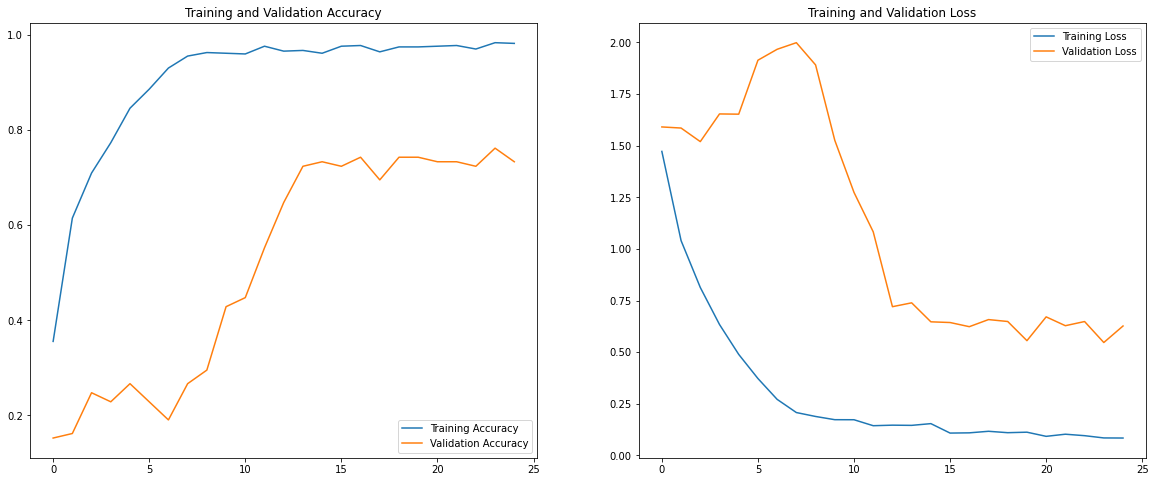

In [41]:
acc = model_4.history.history['categorical_accuracy']
val_acc = model_4.history.history['val_categorical_accuracy']

loss = model_4.history.history['loss']
val_loss = model_4.history.history['val_loss']

epochs_range = range(num_epochs)


plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Even after reducing batch size for the above 2Dconv and LTSM model, overfitting still exists.

#### We will now try to tamper with the filter size, keeping the batch size as 15.

# Model 5 : Conv3D Model : Batch size = 15, filtersize=(2,2,2)

In [42]:
filtersize=(2,2,2)
dropout=0.5
dense_neurons=256
num_classes=5

model_5=Sequential()

model_5.add(Conv3D(16, filtersize, padding='same',input_shape=(16,120,120,3)))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(Conv3D(16, filtersize, padding='same',input_shape=(16,120,120,3)))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(MaxPooling3D(pool_size=(2,2,2)))

model_5.add(Conv3D(32, filtersize, padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(Conv3D(32, filtersize, padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(MaxPooling3D(pool_size=(2,2,2)))

model_5.add(Conv3D(64, filtersize, padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(Conv3D(64, filtersize, padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(MaxPooling3D(pool_size=(2,2,2)))

model_5.add(Conv3D(128, filtersize, padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(Conv3D(128, filtersize, padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())

model_5.add(MaxPooling3D(pool_size=(2,2,2)))

model_5.add(Flatten())
model_5.add(Dense(dense_neurons,activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(dropout))

model_5.add(Dense(dense_neurons,activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(dropout))

model_5.add(Dense(num_classes,activation='softmax'))




In [43]:
optimiser = keras.optimizers.Adam(lr=0.0002)
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 16, 120, 120, 16)  2064      
                                                                 
 activation_17 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_31 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [44]:
batch_size=15
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [45]:
#Model name is given in this format
model_name = 'model_init_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#Check if model exists or not in the directory, if not create it
if not os.path.exists(model_name):
    os.mkdir(model_name)

#Put more formatting
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Using callbacks reduce lr on plateau method 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [46]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [47]:
model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 2.0377 - categorical_accuracy: 0.3481Source path =  datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 2.08744, saving model to model_init_5_2022-10-0913_35_54.468561/model-00001-2.03770-0.34815-2.08744-0.20000.h5
45/45 [==============================] - 56s 1s/step - loss: 2.0377 - categorical_accuracy: 0.3481 - val_loss: 2.0874 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.1900 - categorical_accuracy: 0.5822
Epoch 00002: val_loss did not improve from 2.08744
45/45 [==============================] - 52s 1s/step - loss: 1.1900 - categorical_accuracy: 0.5822 - val_loss: 2.6559 - val_categorical_accuracy: 0.2286 - lr: 2.0000e-04
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 0.9687 - categorical_accuracy: 0.6489
Epoch 00003: val_

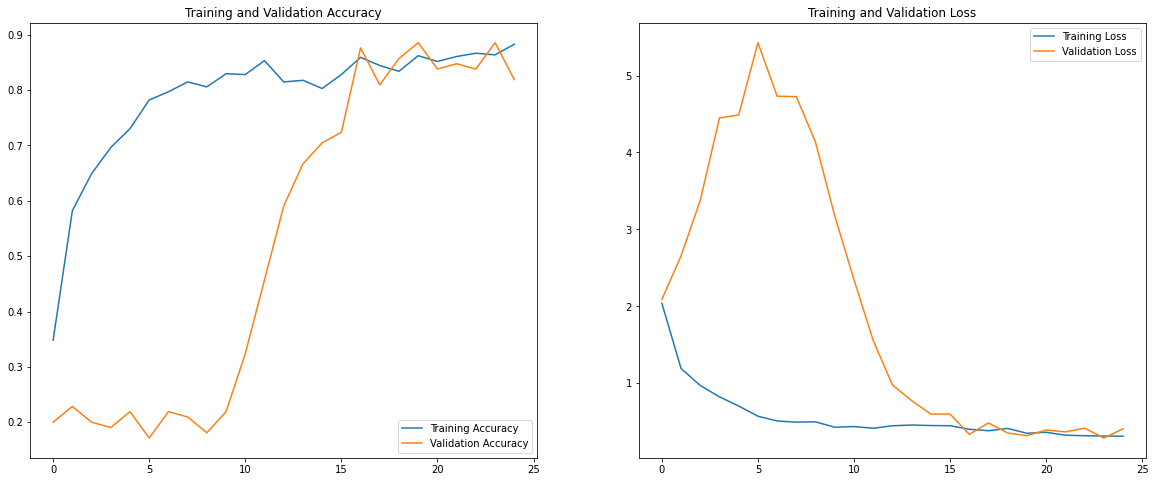

In [48]:
acc = model_5.history.history['categorical_accuracy']
val_acc = model_5.history.history['val_categorical_accuracy']

loss = model_5.history.history['loss']
val_loss = model_5.history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### - Model 5 seems like a perfect model. After the 15th epoch, the val acc overlaps with train acc.
##### - The loss and validation loss keeps reducing with epoch.

# Model 6- Conv2D and LSTM , Batch size= 15, filtersize=(2,2)

In [49]:
model_6= Sequential()
filtersize=(2,2)

model_6.add(TimeDistributed(Conv2D(16,filtersize,padding='same',activation='relu'),input_shape=(16,120,120,3)))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D(2,2)))

model_6.add(TimeDistributed(Conv2D(32,filtersize,padding='same',activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D(2,2)))

model_6.add(TimeDistributed(Conv2D(64,filtersize,padding='same',activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D(2,2)))

model_6.add(TimeDistributed(Conv2D(128,filtersize,padding='same',activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D(2,2)))

model_6.add(TimeDistributed(Conv2D(256,filtersize,padding='same',activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D(2,2)))

model_6.add(TimeDistributed(Flatten()))
model_6.add(LSTM(256))
model_6.add(Dropout(0.25))

model_6.add(Dense(128,activation='relu'))
model_6.add(Dropout(0.25))
model_6.add(Dense(num_classes,activation='softmax'))


In [50]:
optimiser = keras.optimizers.Adam(lr=0.0001)
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 16, 120, 120, 16)  208      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 16, 60, 60, 32)   2080      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 16, 60, 60, 32)  

In [51]:
batch_size=15
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [52]:
#Model name is given in this format
model_name = 'model_init_6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#Check if model exists or not in the directory, if not create it
if not os.path.exists(model_name):
    os.mkdir(model_name)

#Put more formatting
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Using callbacks reduce lr on plateau method 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [53]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [54]:
model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 1.5516 - categorical_accuracy: 0.2815Source path =  datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 1.54386, saving model to model_init_6_2022-10-0913_35_54.468561/model-00001-1.55155-0.28148-1.54386-0.20952.h5
45/45 [==============================] - 55s 1s/step - loss: 1.5516 - categorical_accuracy: 0.2815 - val_loss: 1.5439 - val_categorical_accuracy: 0.2095 - lr: 1.0000e-04
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.1303 - categorical_accuracy: 0.5748
Epoch 00002: val_loss improved from 1.54386 to 1.53995, saving model to model_init_6_2022-10-0913_35_54.468561/model-00002-1.13033-0.57481-1.53995-0.20952.h5
45/45 [==============================] - 53s 1s/step - loss: 1.1303 - categorical_accuracy: 0.5748 - val_loss: 1.5400 - val_categorical_accuracy: 0.2095 - lr: 1.0000e-04
Epoch 3/25
45/45

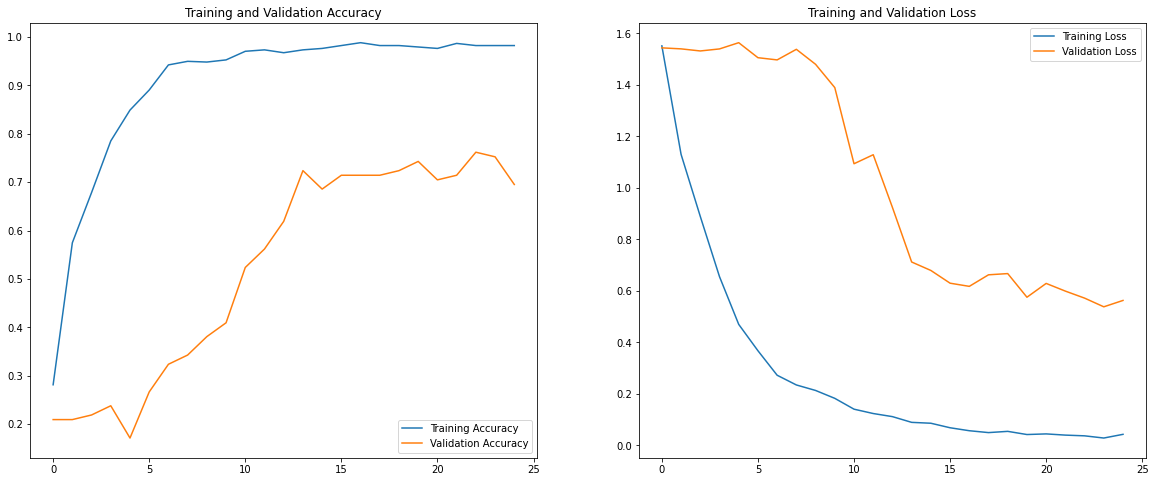

In [55]:
acc = model_6.history.history['categorical_accuracy']
val_acc = model_6.history.history['val_categorical_accuracy']

loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs_range = range(num_epochs)


plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### - The above model does overfits.


# Model 7- CNN + GRU , Batch size= 15, filtersize=(2,2)

In [56]:
model_7= Sequential()
filtersize=(2,2)

model_7.add(TimeDistributed(Conv2D(16,filtersize,padding='same',activation='relu'),input_shape=(16,120,120,3)))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D(2,2)))

model_7.add(TimeDistributed(Conv2D(32,filtersize,padding='same',activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D(2,2)))

model_7.add(TimeDistributed(Conv2D(64,filtersize,padding='same',activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D(2,2)))

model_7.add(TimeDistributed(Conv2D(128,filtersize,padding='same',activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D(2,2)))

model_7.add(TimeDistributed(Conv2D(256,filtersize,padding='same',activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D(2,2)))

model_7.add(TimeDistributed(Flatten()))
model_7.add(GRU(units=128, return_sequences=True, activation='tanh', recurrent_dropout=0.5))
model_7.add(Dropout(0.5))
model_7.add(GRU(units=50, activation='tanh', recurrent_dropout=0.5))
model_7.add(Dropout(0.5))

model_7.add(Dense(128,activation='relu'))
model_7.add(Dropout(0.25))
model_7.add(Dense(num_classes,activation='softmax'))


In [57]:
optimiser = keras.optimizers.Adam(lr=0.0001)
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 16, 120, 120, 16)  208      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 16, 60, 60, 32)   2080      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 16, 60, 60, 32)  

In [58]:
batch_size=15
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [59]:
#Model name is given in this format
model_name = 'model_init_7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#Check if model exists or not in the directory, if not create it
if not os.path.exists(model_name):
    os.mkdir(model_name)

#Put more formatting
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Using callbacks reduce lr on plateau method 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [60]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [61]:
model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 1.6706 - categorical_accuracy: 0.2089Source path =  datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 1.54583, saving model to model_init_7_2022-10-0913_35_54.468561/model-00001-1.67056-0.20889-1.54583-0.20000.h5
45/45 [==============================] - 54s 1s/step - loss: 1.6706 - categorical_accuracy: 0.2089 - val_loss: 1.5458 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.4559 - categorical_accuracy: 0.3319
Epoch 00002: val_loss did not improve from 1.54583
45/45 [==============================] - 49s 1s/step - loss: 1.4559 - categorical_accuracy: 0.3319 - val_loss: 1.5887 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 1.3487 - categorical_accuracy: 0.4459
Epoch 00003: val_

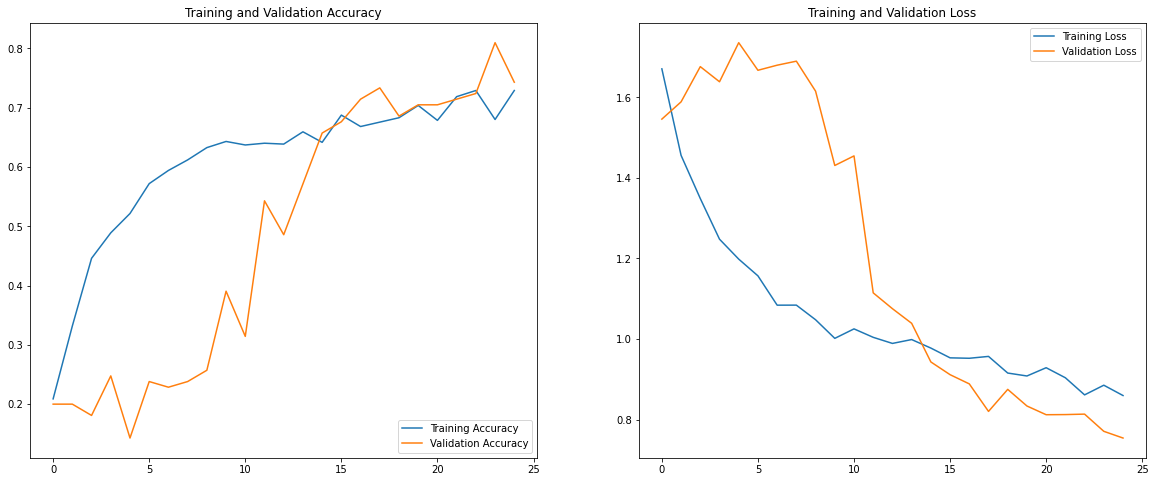

In [63]:
acc = model_7.history.history['categorical_accuracy']
val_acc = model_7.history.history['val_categorical_accuracy']

loss = model_7.history.history['loss']
val_loss = model_7.history.history['val_loss']

epochs_range = range(num_epochs)


plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### - The above model overfits initially, but with increasing epoch the accuracy improves significantly. 


# Model 5 : Chosen as final model 

In [29]:
# loading the final model  at the 24th epoch.

from keras.models import load_model
model=load_model('model_init_5_2022-10-0913_35_54.468561/model-00024-0.31142-0.86370-0.28595-0.88571.h5')



In [31]:
random_img = generator('datasets/Project_data/val',val_doc, batch_size = 10)
random_img_data, random_img_label = next(random_img)

# Actual Class
print('Actual Class of the Image:    ', list(random_img_label[0]).index(1))

# Predicted Class from the model
print('Predicted Class of the Image: ', np.argmax(model.predict(random_img_data), axis = 1)[0])

Source path =  datasets/Project_data/val ; batch size = 10
Actual Class of the Image:     3
Predicted Class of the Image:  3


In [ ]:
The model has correctly predicted the chosen random image. 